In [1]:
# https://github.com/matterport/Mask_RCNN    
import cv2 as cv2
import argparse
import numpy as np
import os.path
import sys
import random

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

In [3]:
# Draw the predicted bounding box, colorize and show the mask on the image

def drawBox(frame, classId, conf, left, top, right, bottom, classMask): 
    
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

    classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    
    #현재 검출된 위치의 이미지
    #원본 이미지에서 마스크에 해당하는 부분만 가져온다.
    roi = frame[top:bottom+1, left:right+1][mask]
    
    #for문장 으로도 가능하다.
    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]                 # mask 가중치    
    #원본영상에 대해서는 0.3, mask에 대해서는 0.7을 준다.
    frame[top:bottom+1, left:right+1][mask] = ([0.7*color[0], 0.7*color[1], 0.7*color[2]] + 0.3 * roi).astype(np.uint8)

    
def postprocess(boxes, masks):
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    frameH = frame.shape[0]
    frameW = frame.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]  # 7개 정보  ?, classid, score, left, top #score 해당 클래스일 확률
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            #박스가 이미지 밖으로 나가는 일이 없다.
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]
            
            #마스크를 15*15로 준다. 마스크 결과에는 위치정보가 없다. 

            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)



In [9]:
#얘는 클래스가 90개로 가정하고 문제를 풀었다.
classesFile = "mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
   classes = f.read().rstrip('\n').split('\n')

textGraph = "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "frozen_inference_graph.pb"   # 다운받아야 함

# Load the network
net = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Load the classes
colorsFile = "colors.txt"; #그냥 색깔정보가 담긴 파일
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)

mscoco_labels.names


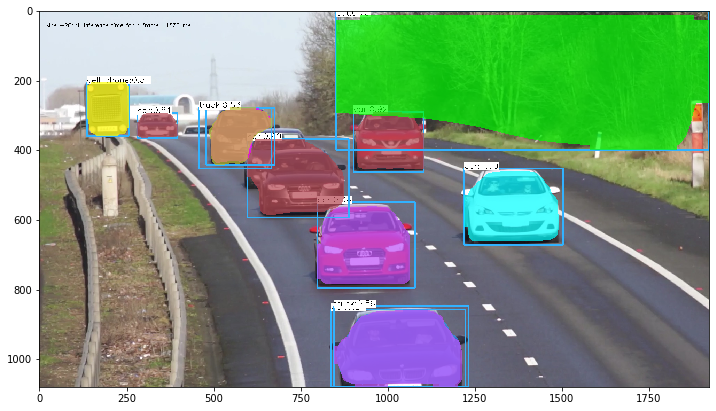

In [15]:
frame = cv2.imread('cars.jpg')

#얘를 꼭 써야하는것은 아니다.
blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)

net.setInput(blob)

#Output이 2개다. 객체 검출과, 검출된 객체에 대해서, Segmentation을 위해
boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

postprocess(boxes, masks)

#걸린 시간 측정
t, _ = net.getPerfProfile()

label = 'Mask-RCNN, Inference time for a frame : %0.0f ms' % abs(t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

cv2.imwrite("output.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (12, 12))
plt.imshow(img)

(1, 1, 100, 7)
(100, 90, 15, 15)
[0.        2.        0.8138807 0.4361228 0.7943884 0.6365958 1.       ]
2
0.99808925


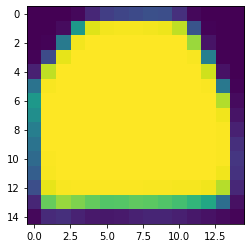

0.93989766


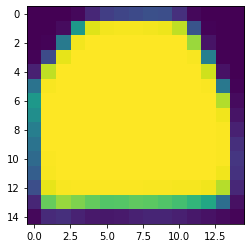

0.91791123


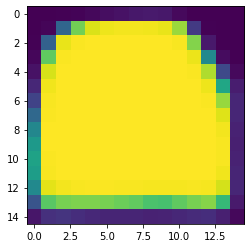

0.9024395


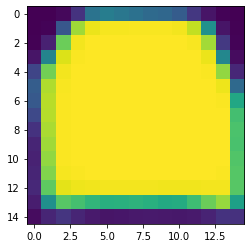

0.84267706


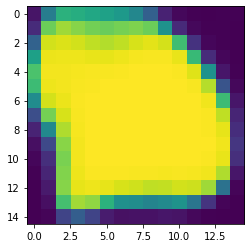

0.8138807


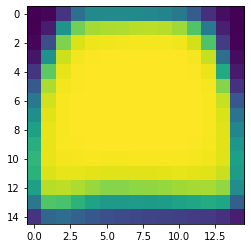

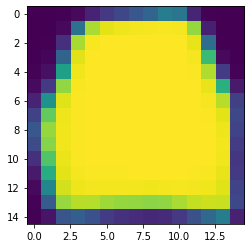

In [75]:
print(boxes.shape)   # 1,1,100box,7개 정보
print(masks.shape)   # 100개box, 90개클래스, mask, 90개 클래스에 대한 mask값을 다 준다. mask는 크기가 정말 작은 2차원
#모든 마스크의 크기는 15*15

print(boxes[0,0,5])  # 5번째 box
id = int(boxes[0,0,5,1])
print(id)

m = masks[0,id, :, :] #가장 맨 앞에 있는 수번째 마스크를 보여준다.
plt.imshow(m)

for i in range(6):
    m = masks[i, id, :, :]
    print(boxes[0, 0, i, 2])
    plt.show()
    plt.imshow(m)

s = np.hstack([m])
plt.imshow(s)